# Image Segementation

Threshold Based Segementation

In [5]:
import cv2 
import numpy as np 

In [6]:
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow as ims

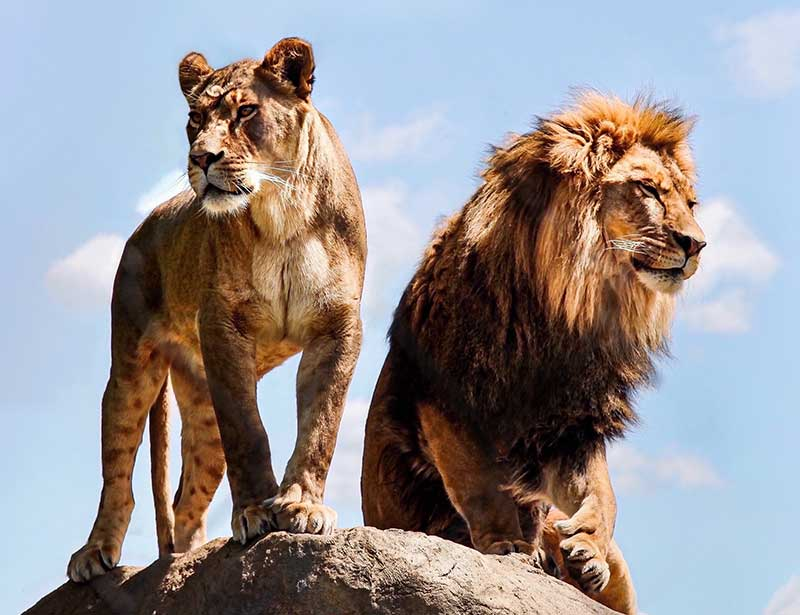

In [7]:
lion = cv2.imread("/content/lion.jpg")
ims(lion)

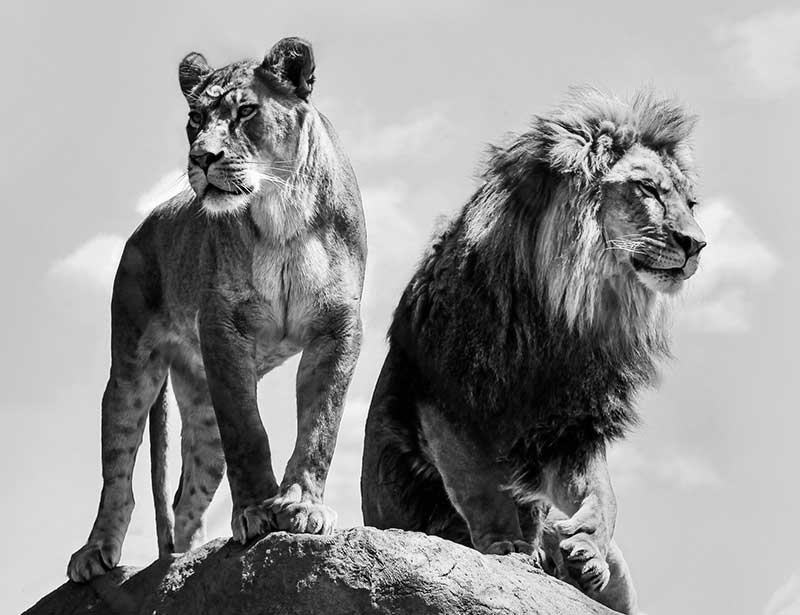

In [8]:
img_gray = cv2.cvtColor(lion, cv2.COLOR_BGR2GRAY)
ims(img_gray) 

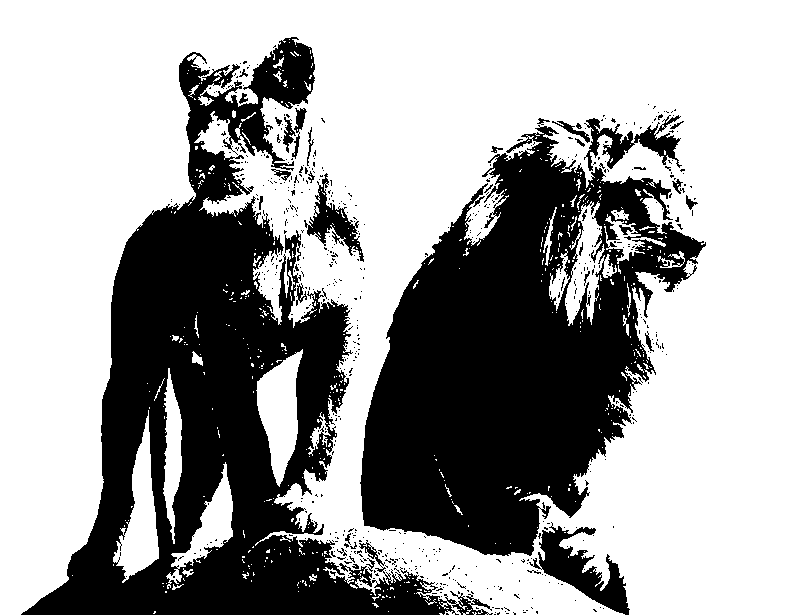

In [9]:
## Binary thresholding of image 
threshold_value = 128
binary_image = binary_image = np.where(img_gray >= threshold_value, 255, 0).astype(np.uint8)
ims(binary_image)

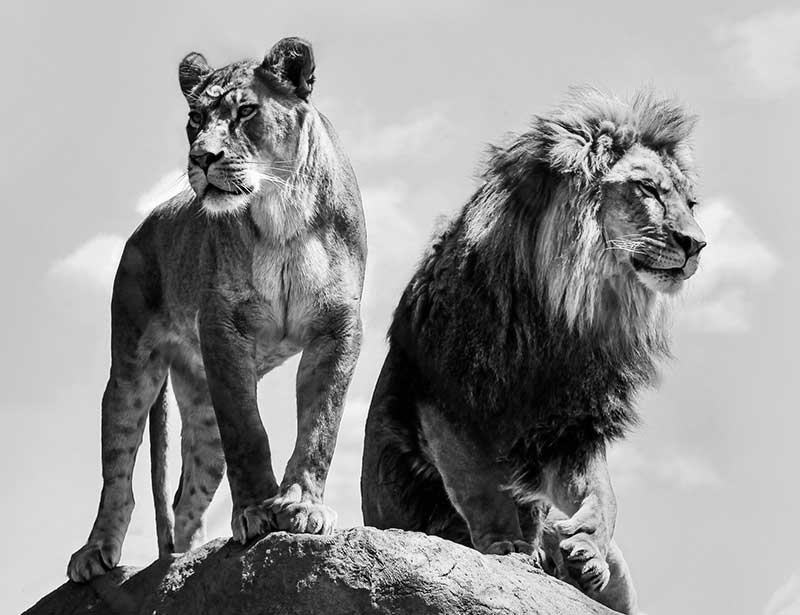

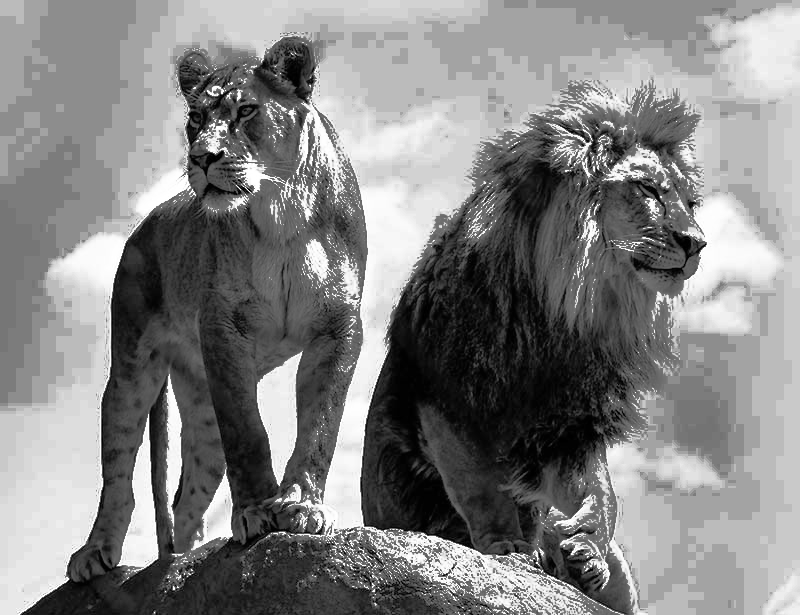

In [10]:
ims(img_gray)
equ = cv2.equalizeHist(img_gray)
res = np.hstack((img_gray,equ)) #stacking images side-by-side
ims(equ)

### Sobel Edge Detection

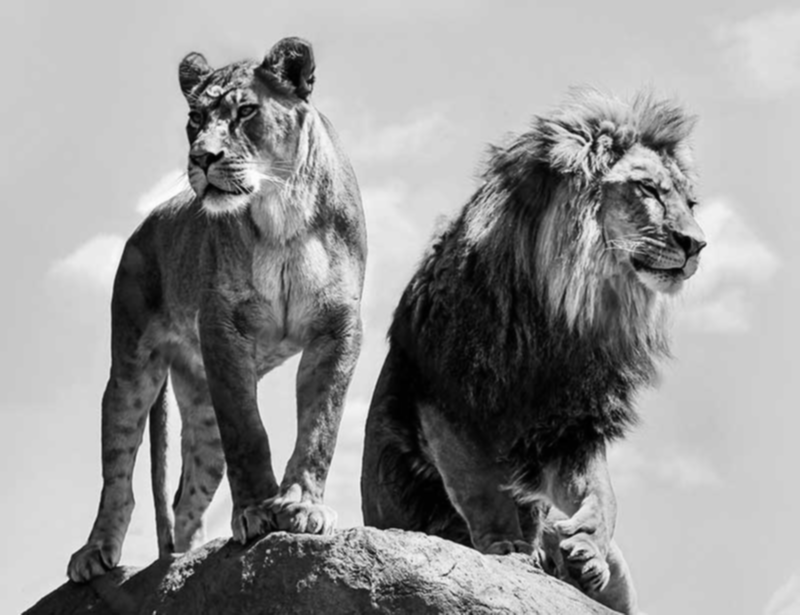

In [11]:
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 
ims(img_blur) 

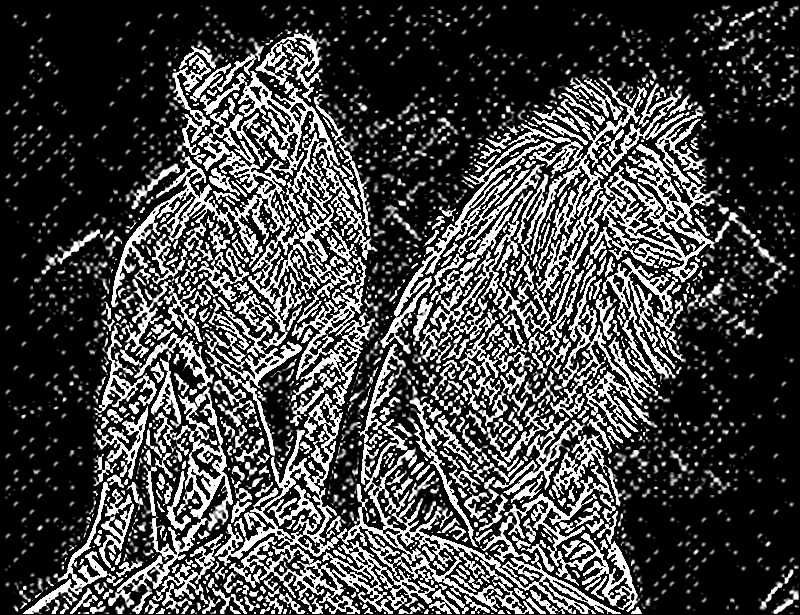

In [12]:
# Sobel Edge Detection
sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=7) # Sobel Edge Detection on the X axis
sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=7) # Sobel Edge Detection on the Y axis
sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=7) # Combined X and Y Sobel Edge Detection
# Display Sobel Edge Detection Images
ims(sobelxy)

### It is able to find the edges pretty well but there is a lot of noise, this can this be removed by doing an erosion operation

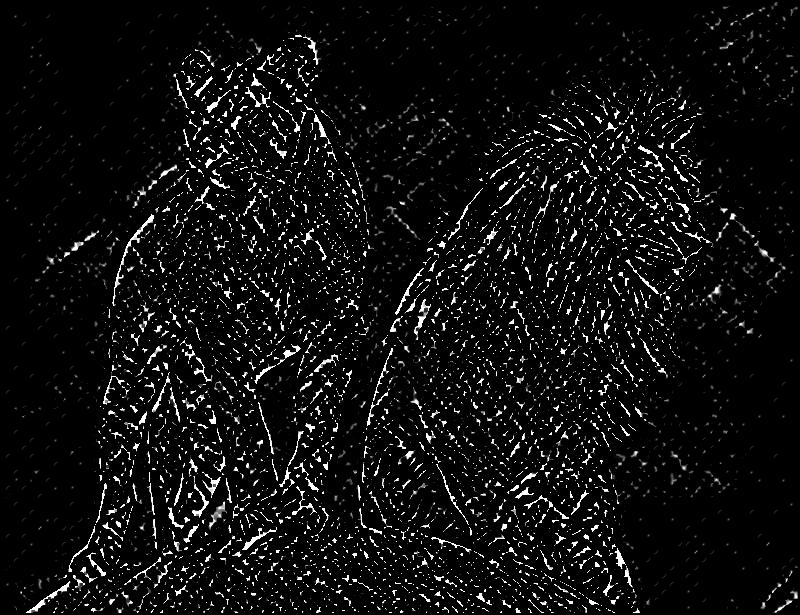

In [13]:
kernel = np.ones((3, 3), np.uint8)
erosion = cv2.erode(sobelxy,kernel,iterations=1) 
ims(erosion)

## Canny Edge Detection

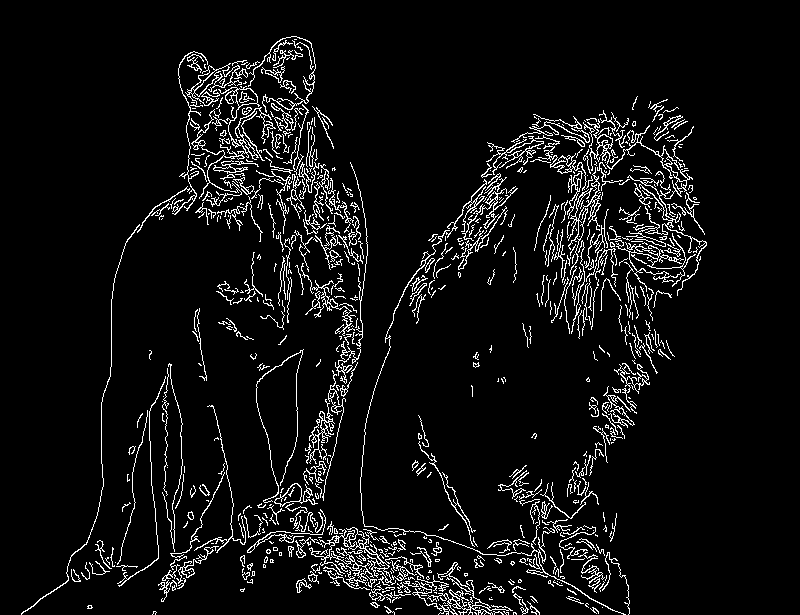

In [14]:
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
# Display Canny Edge Detection Image
ims(edges)

### Canny Edge detection gives a pretty good ooutline compared to Sobel 

### Region based segmentation

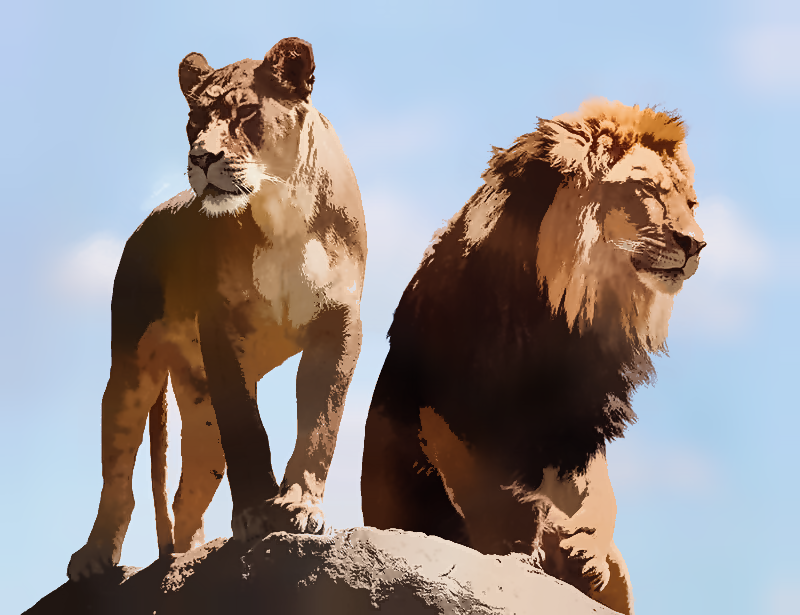

In [26]:
shifted = cv2.pyrMeanShiftFiltering(lion, 21, 51)
ims(shifted)

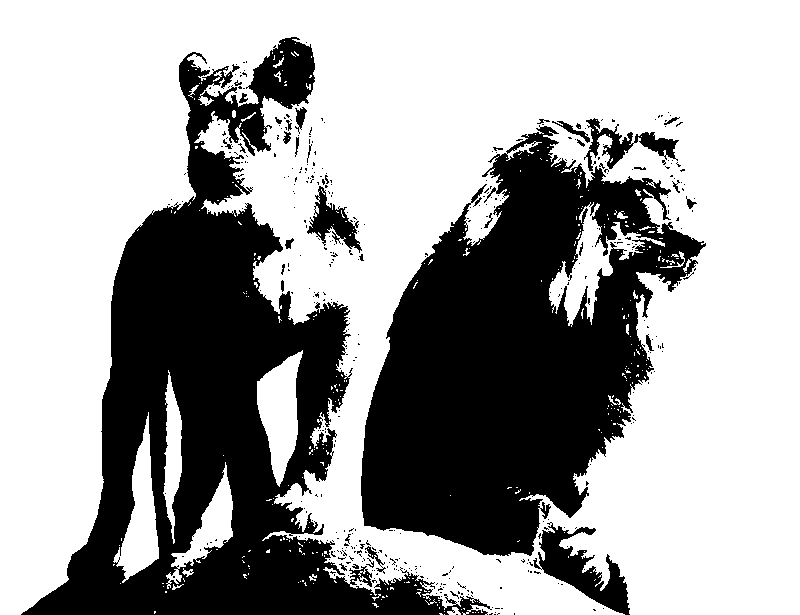

In [27]:
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
ims(thresh)

### Clustering based thresholding
k means clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(-0.5, 799.5, 614.5, -0.5)

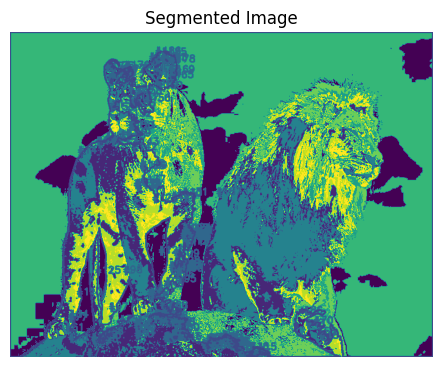

In [48]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
pixels = lion.reshape(-1, 3)

# Perform K-means clustering
kmeans = KMeans(n_clusters=10)
kmeans.fit(pixels)

# Get the labels assigned to each pixel
labels = kmeans.labels_

# Reshape the labels back to the original image shape
segmented_image = labels.reshape(lion.shape[:2])

# Display the segmented image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='viridis')
plt.title('Segmented Image')
plt.axis('off')


## Semantic Segmentation 

In [41]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [42]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

In [43]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

In [44]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [45]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('/content/int.jpg').convert('RGB')
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

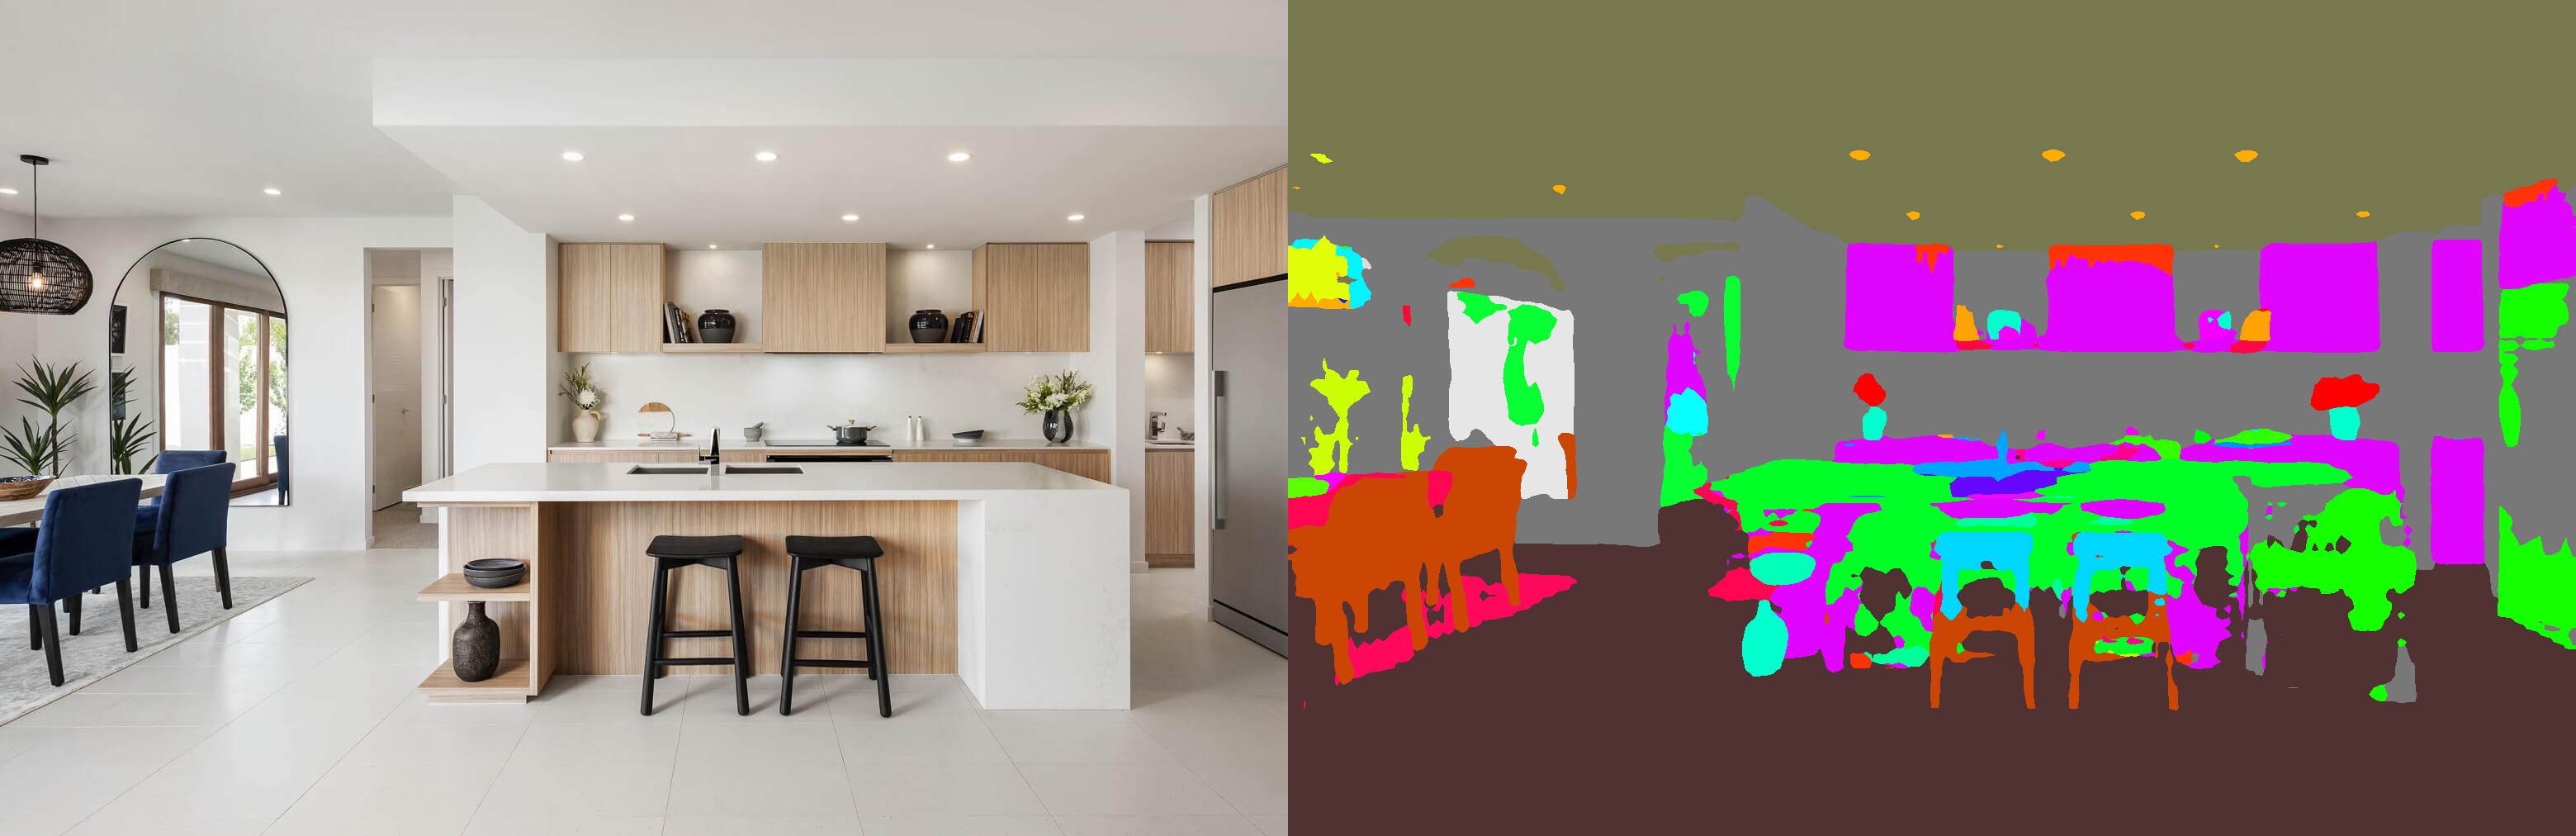

In [46]:
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

In [47]:
# Top classes in answer
predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
for c in predicted_classes[:15]:
    visualize_result(img_original, pred, c)

Output hidden; open in https://colab.research.google.com to view.